In [36]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
from datetime import timedelta

# visualization
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)

In [37]:
def load_df(path, columns=None, use_threads=True):
    try:
        return pq.read_table(path, columns=columns, use_threads=use_threads).to_pandas()
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    
    return df
        
def prepare(path,cols):

    df = load_df(path,cols)
    df = df.reset_index(drop=True)
    df = downcast_ints(df)
    
    return df

In [52]:
def pieOthers(dfVars,dfVals,threshold):
    df = pd.DataFrame(
        data = {'var': dfVars, 'value' : dfVals},
        ).sort_values('value', ascending = False)
    
    if threshold > 0 :
        df2 = df[:threshold].copy()
        new_row = pd.DataFrame(data = {
            'var' : ['Others'],
            'value' : [dfVals[threshold:].sum()]
        })

        df2 = pd.concat([df2, new_row])
    else:
        df2 = df
        
    percent = 100.*df2['value']/df2['value'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df2['var'], percent)]
    #labels = ['{0} - {1}'.format(i,j) for i,j in zip(df2['var'], df2['value'])]
    
    colorsX = plt.cm.tab20.colors
    patches, texts = plt.pie(df2['value'], shadow=True, startangle=90, colors = colorsX)
    plt.legend(patches, labels, loc="best")
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
def pieOthers2(dfVars,dfVals,threshold):
    df = pd.DataFrame(
        data = {'var': dfVars, 'value' : dfVals},
        ).sort_values('value', ascending = False)
    
    if threshold > 0 :
        df2 = df[:threshold].copy()
        new_row = pd.DataFrame(data = {
            'var' : ['Others'],
            'value' : [dfVals[threshold:].sum()]
        })

        df2 = pd.concat([df2, new_row])
    else:
        df2 = df
    
    percent = 100.*df2['value']/df2['value'].sum()
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df2['var'], percent)]
    
    #labels = ['{0} - {1}'.format(i,j) for i,j in zip(df2['var'], df2['value'])]
    
    fig=plt.figure(figsize=(7,5))
    gs1 = gridspec.GridSpec(1,1,
        left=0.1,right=0.7,
        bottom=0.1,top=0.7,
    )
    pie_ax=fig.add_subplot(gs1[0])
    
    colors = plt.cm.tab20.colors
    wedges, texts = pie_ax.pie(
        df2['value'],
        shadow=True,
        colors=colors,
        startangle=90,
    )
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"), zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle,"color":colors[i]})
        pie_ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                     horizontalalignment=horizontalalignment, **kw)
    pie_ax.axis('equal')

    plt.show()

In [39]:
cols = ['model', 'manufacturer', 'brand', 'product', 'os_version', 'codename', 'kernel_version', 'is_root']
df = prepare('datasets/devices.parquet',cols)

In [40]:
df.head(100)

,model,manufacturer,brand,product,os_version,codename,kernel_version,is_root
0,VS500PP,LGE,LGE,M1V_PP_VZW,6.0.1,Marshmallow,3.10.49-gf18313b-00011-g5e5ed63,0
1,AO5510,YU,YU,YUREKA,5.1.1,Lollipop,3.10.49-cyanogenmod-gbca6118,1
2,ASUS_X014D,ASUS,ASUS,WW_PHONE,5.1.1,Lollipop,3.4.0-gdf95949-dirty,0
3,NEXUS 5,LGE,GOOGLE,HAMMERHEAD,6.0.1,Marshmallow,3.4.0-gcf10b7e,0
4,LG-D331,LGE,LGE,LUV80SS_GLOBAL_COM,4.4.2,KitKat,3.4.67,0
5,NEXUS 5,LGE,GOOGLE,HAMMERHEAD,6.0.1,Marshmallow,3.4.0-gcf10b7e,0
6,HUAWEI P7-L10,HUAWEI,HUAWEI,P7-L10,5.1.1,Lollipop,3.0.8-00595-gc29cecf,0
7,ONE A2003,ONEPLUS,ONEPLUS,ONEPLUS2,6.0.1,Marshmallow,3.10.84-perf+,0
8,SM-G903F,SAMSUNG,SAMSUNG,S5NEOLTEXX,6.0.1,Marshmallow,3.10.61-10798689,0
9,ALE-L21,HUAWEI,HUAWEI,ALE-L21,6.0,Marshmallow,3.10.86-gff4393b,0


In [41]:
dfModelGB = df.groupby(['model'])['model'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfManufacturerGB = df.groupby(['manufacturer'])['manufacturer'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfBrandGB = df.groupby(['brand'])['brand'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfProductGB = df.groupby(['product'])['product'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfOsVersionGB = df.groupby(['os_version'])['os_version'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)
dfCodenameGB = df.groupby(['codename'])['codename'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(20)

In [42]:
print("Devices:"+str(len(df.index)))

Devices:35768


                model  count
4376         SM-J200G    755
3866         REDMI 5A    438
3862         REDMI 4A    381
4221         SM-G532G    342
5132        VIVO 1606    329
232              A37F    316
4453         SM-J700F    273
374           ALE-L21    232
3872     REDMI NOTE 4    227
4222         SM-G532M    224
4239         SM-G610F    187
4460         SM-J701F    177
4366         SM-J111F    177
233             A37FW    176
413   ANDROMAX A16C3H    165
4380         SM-J210F    158
4321         SM-G935F    154
4218         SM-G531H    148
3163       MOTO E (4)    146
4220         SM-G532F    145


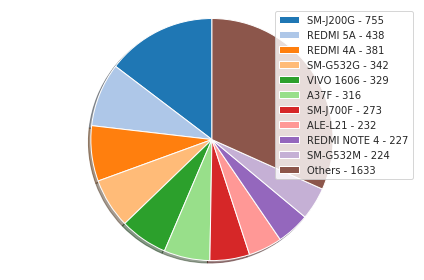

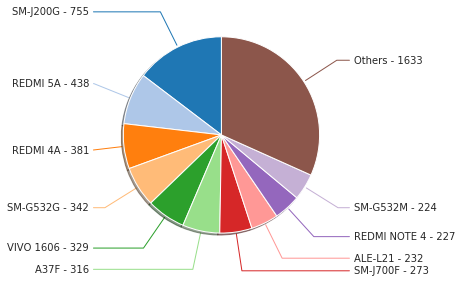

In [43]:
print(dfModelGB)
pieOthers(dfModelGB['model'],dfModelGB['count'],10)
pieOthers2(dfModelGB['model'],dfModelGB['count'],10)

    manufacturer  count
651      SAMSUNG   9594
845       XIAOMI   2387
296       HUAWEI   1956
432          LGE   1747
557         OPPO   1480
503     MOTOROLA   1400
809         VIVO   1221
426       LENOVO   1124
479     MICROMAX   1012
417         LAVA    711
70          ASUS    696
878          ZTE    672
725          TCL    660
18         ADVAN    474
683         SONY    390
351         ITEL    382
335        INTEX    345
602      QMOBILE    333
271        HAIER    317
35          ALPS    264


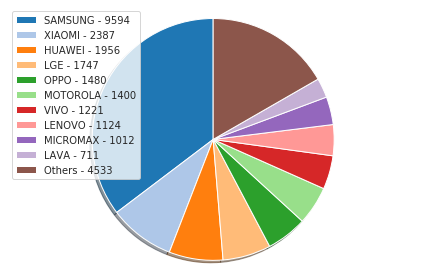

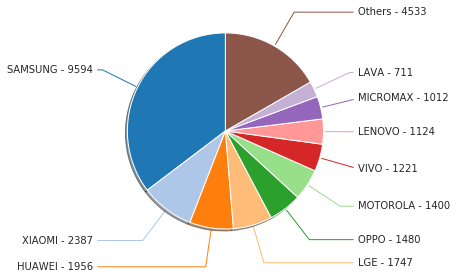

In [44]:
print(dfManufacturerGB)
pieOthers(dfManufacturerGB['manufacturer'],dfManufacturerGB['count'],10)
pieOthers2(dfManufacturerGB['manufacturer'],dfManufacturerGB['count'],10)

         brand  count
716    SAMSUNG   9469
912     XIAOMI   2387
330     HUAWEI   1740
477        LGE   1629
615       OPPO   1480
545   MOTOROLA   1395
877       VIVO   1224
470     LENOVO   1122
516   MICROMAX   1003
791        TCL    738
90        ASUS    690
463       LAVA    675
945        ZTE    671
30       ADVAN    484
388       ITEL    438
748       SONY    370
665    QMOBILE    345
371      INTEX    332
742  SMARTFREN    312
488        LYF    286


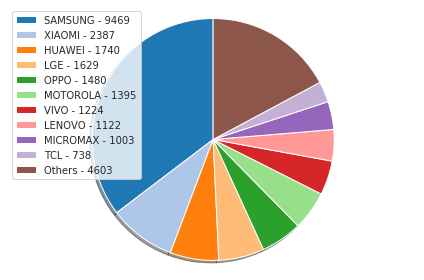

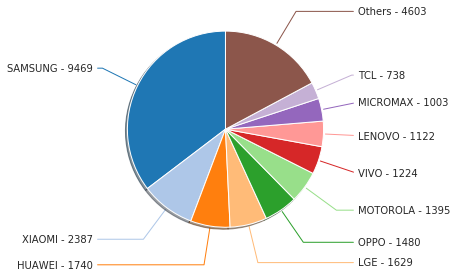

In [45]:
print(dfBrandGB)
pieOthers(dfBrandGB['brand'],dfBrandGB['count'],10)
pieOthers2(dfBrandGB['brand'],dfBrandGB['count'],10)

           product  count
2552       J2LTEDD    755
4274          RIVA    437
4290         ROLEX    379
5372      WW_PHONE    366
6             1606    359
1995  GRANDPPLTEDX    326
281           A37F    316
2655      J7ELTEXX    269
485        ALE-L21    232
1998  GRANDPPLTEUB    224
3334          MIDO    181
2982       LEPHONE    180
2518  J1ACEVELTEJV    177
2671     J7VELTEDX    177
282          A37FW    176
4441       SANTONI    175
3631    ON7XELTEDD    168
235         A16C3H    162
2167    HERO2LTEXX    152
4125      Q402PLUS    150


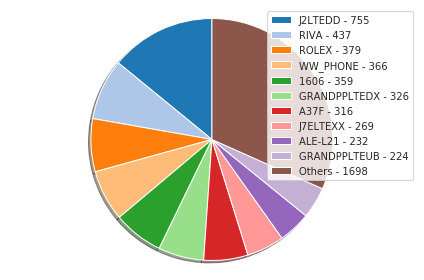

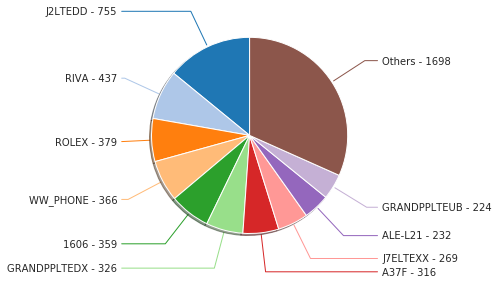

In [46]:
print(dfProductGB)
pieOthers(dfProductGB['product'],dfProductGB['count'],10)
pieOthers2(dfProductGB['product'],dfProductGB['count'],10)

   os_version  count
24        7.0   6531
20        6.0   5666
22      6.0.1   5447
18      5.1.1   4886
17        5.1   3449
27      7.1.1   1776
28      7.1.2   1460
32      8.1.0   1319
30      8.0.0   1221
16      5.0.2   1140
14        5.0    790
11      4.4.2    786
15      5.0.1    391
13      4.4.4    283
6       4.2.2    205
4       4.1.2    119
33          9     82
7         4.3     72
3       4.1.1     27
23        6.1     25


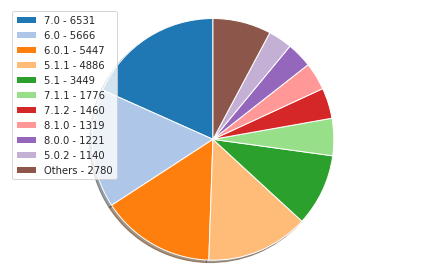

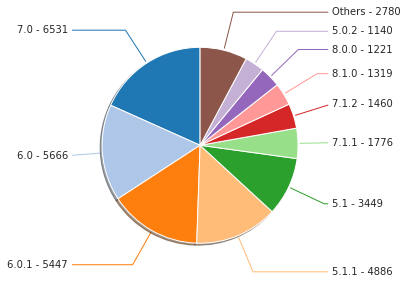

In [47]:
print(dfOsVersionGB)
pieOthers(dfOsVersionGB['os_version'],dfOsVersionGB['count'],10)
pieOthers2(dfOsVersionGB['os_version'],dfOsVersionGB['count'],10)

             codename  count
4         Marshmallow  11152
3            Lollipop  10658
6              Nougat   9786
7                Oreo   2546
2              KitKat   1072
1          Jelly Bean    450
8                 Pie     84
0  Ice Cream Sandwich     19
5         No Codename      1


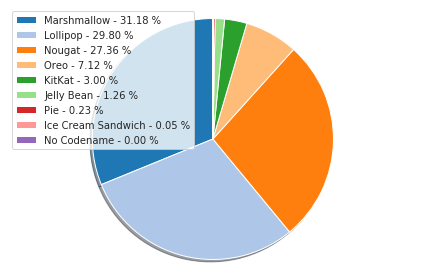

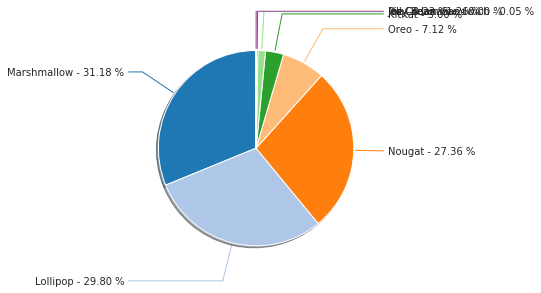

In [53]:
print(dfCodenameGB)
pieOthers(dfCodenameGB['codename'],dfCodenameGB['count'],0)
pieOthers2(dfCodenameGB['codename'],dfCodenameGB['count'],0)